C:\Users\MadiL\AppData\Local\Temp\ipykernel_20752\3923729124.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['NormalizedValue'] = filtered_df.apply(


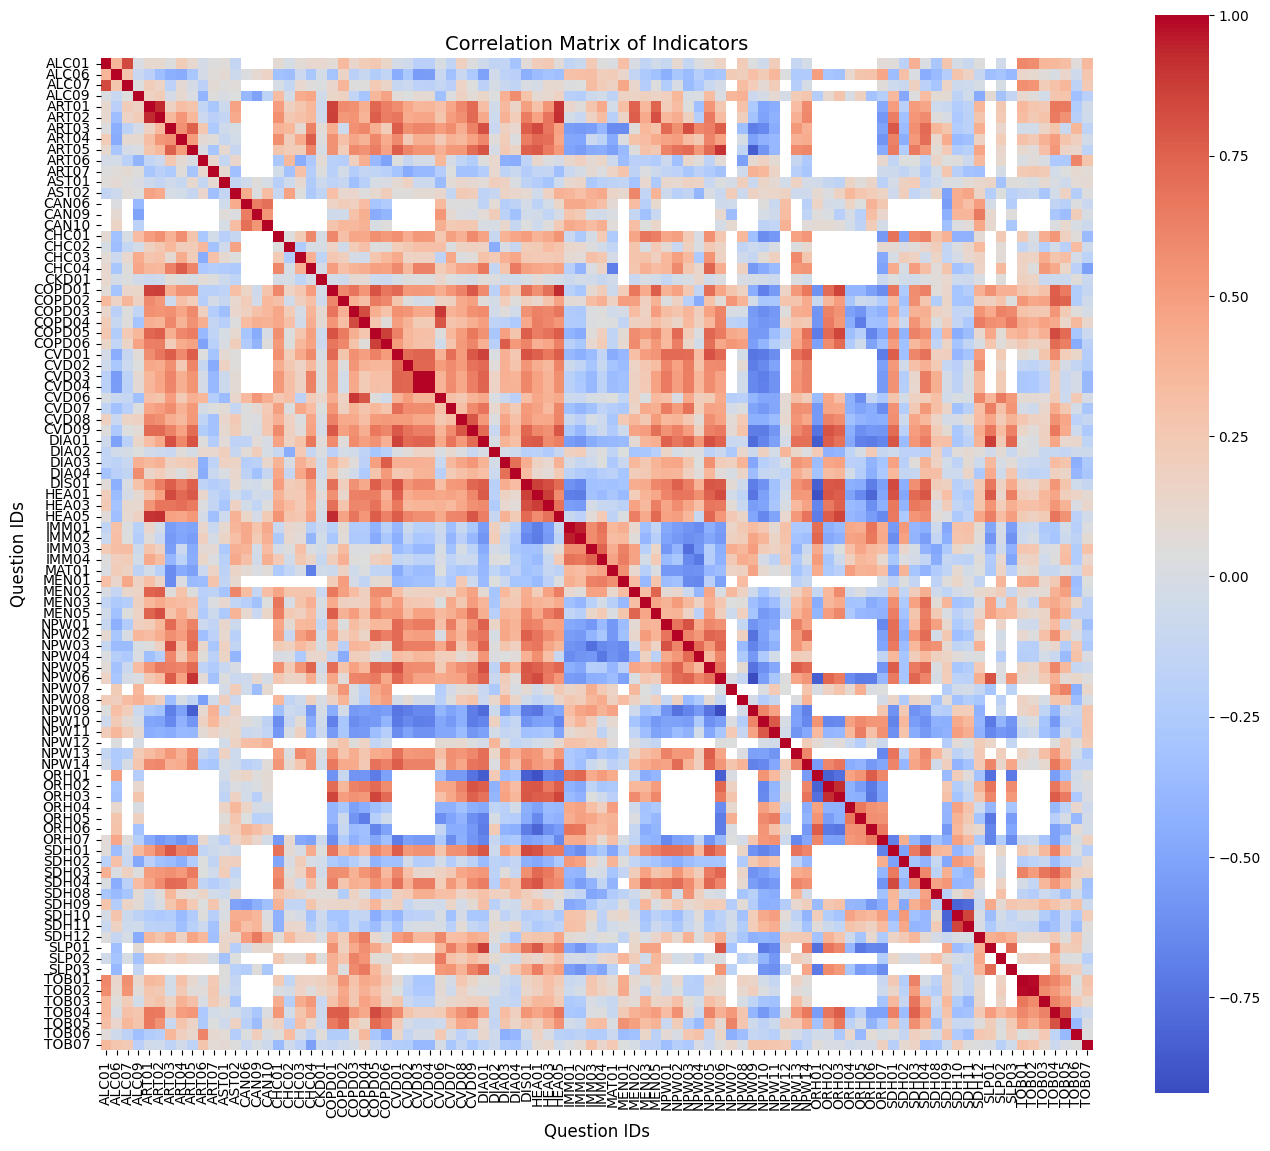

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'U.S._Chronic_Disease_Indicators.csv'
df = pd.read_csv(file_path)

#Step 1: Filter to 'OVERALL' stratification
overall_df = df[df['StratificationID1'] == 'OVR']

# Align to a common year range (2019-2021)
common_year_range = (2019, 2021)
filtered_df = overall_df[
    (overall_df['YearStart'] >= common_year_range[0]) & 
    (overall_df['YearEnd'] <= common_year_range[1])
]

# Normalize units by converting rates to percentages where possible
conversion_factors = {
    'cases per 100,000': 0.001,
    'cases per 1,000': 0.1,
    'cases per 1,000,000': 0.0001,
    'per 100,000': 0.001,
}

filtered_df['NormalizedValue'] = filtered_df.apply(
    lambda row: row['DataValue'] * conversion_factors[row['DataValueUnit']]
    if row['DataValueUnit'] in conversion_factors else row['DataValue'], axis=1
)

# Combine both original percentages and normalized percentage measures
percentage_like_df = filtered_df[
    (filtered_df['DataValueUnit'] == '%') | 
    (filtered_df['DataValueUnit'].isin(conversion_factors.keys()))
]

# Pivot to wide format
wide_df = percentage_like_df.pivot_table(
    index=['LocationAbbr', 'YearStart'],
    columns='QuestionID',
    values='NormalizedValue',
    aggfunc='mean'
).reset_index()

#ID to wuestion mapping
question_mapping = percentage_like_df[['QuestionID', 'Question']].drop_duplicates().set_index('QuestionID')['Question'].to_dict()

# Calculate the correlation matrix
correlation_matrix = wide_df.iloc[:, 2:].corr()  # Exclude non-measure columns like LocationAbbr and YearStart


# Create a correlation matrix heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(
    correlation_matrix,
    cmap='coolwarm',
    square=True,
    cbar=True,
    annot=False,
    xticklabels=True,
    yticklabels=True
)
plt.title('Correlation Matrix of Indicators', fontsize=14)
plt.xlabel('Question IDs', fontsize=12)
plt.ylabel('Question IDs', fontsize=12)
plt.show()

In [ ]:
correlations = correlation_matrix.unstack()
correlations = correlations[correlations != 1]  # Exclude self-correlations

# Sort correlations and filter for cross-topic correlations
cross_topic_correlations = []
for (qid1, qid2), correlation in correlations.items():
    prefix1, prefix2 = qid1[:3], qid2[:3]
    if prefix1 != prefix2:  # Only include correlations across different topics
        cross_topic_correlations.append((correlation, qid1, qid2))

# Sort by correlation (highest to lowest)
cross_topic_correlations.sort(reverse=True)
# Display top 10 and bottom 10 cross-topic correlations
top_10 = cross_topic_correlations[:10]
bottom_10 = cross_topic_correlations[-10:]

def print_correlations(correlations, title):
    print(title)
    for correlation, qid1, qid2 in correlations:
        question1 = question_mapping.get(qid1, 'N/A')
        question2 = question_mapping.get(qid2, 'N/A')
        prefix1, prefix2 = qid1[:3], qid2[:3]
        print(f"Correlation: {correlation:.3f}")
        print(f" - [{prefix1}] {question1}")
        print(f" - [{prefix2}] {question2}\n")

print_correlations(top_10, "Top 10 Cross-Topic Correlations:")
print_correlations(bottom_10, "Bottom 10 Cross-Topic Correlations:")

cross_topic_correlations



Top 10 Cross-Topic Correlations:
Correlation: 0.889
 - [COP] Hospitalization for chronic obstructive pulmonary disease as any diagnosis, Medicare-beneficiaries aged 65 years and older
 - [CVD] Hospitalization for heart failure as principal diagnosis, Medicare-beneficiaries aged 65 years and older

Correlation: 0.859
 - [CVD] High blood pressure among adults
 - [DIA] Diabetes among adults

Correlation: 0.850
 - [COP] Chronic obstructive pulmonary disease mortality among adults aged 45 years and older, underlying cause
 - [ORH] All teeth lost among adults aged 65 years and older

Correlation: 0.829
 - [COP] Chronic obstructive pulmonary disease mortality among adults aged 45 years and older, underlying cause
 - [TOB] Current cigarette smoking among adults

Correlation: 0.773
 - [CVD] High blood pressure among adults
 - [ART] Severe joint pain among adults with arthritis

Correlation: 0.764
 - [CVD] High blood pressure among adults
 - [ART] Physical inactivity among adults with arthritis
